# CORE

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 12)
import matplotlib.pyplot as plt

In [3]:
from CarlaBEV.envs.utils import load_map

rgbmap, _, _ = load_map(size=1024)

print(f"Image Size: {rgbmap.shape}")

Image Size: (10240, 8192, 3)


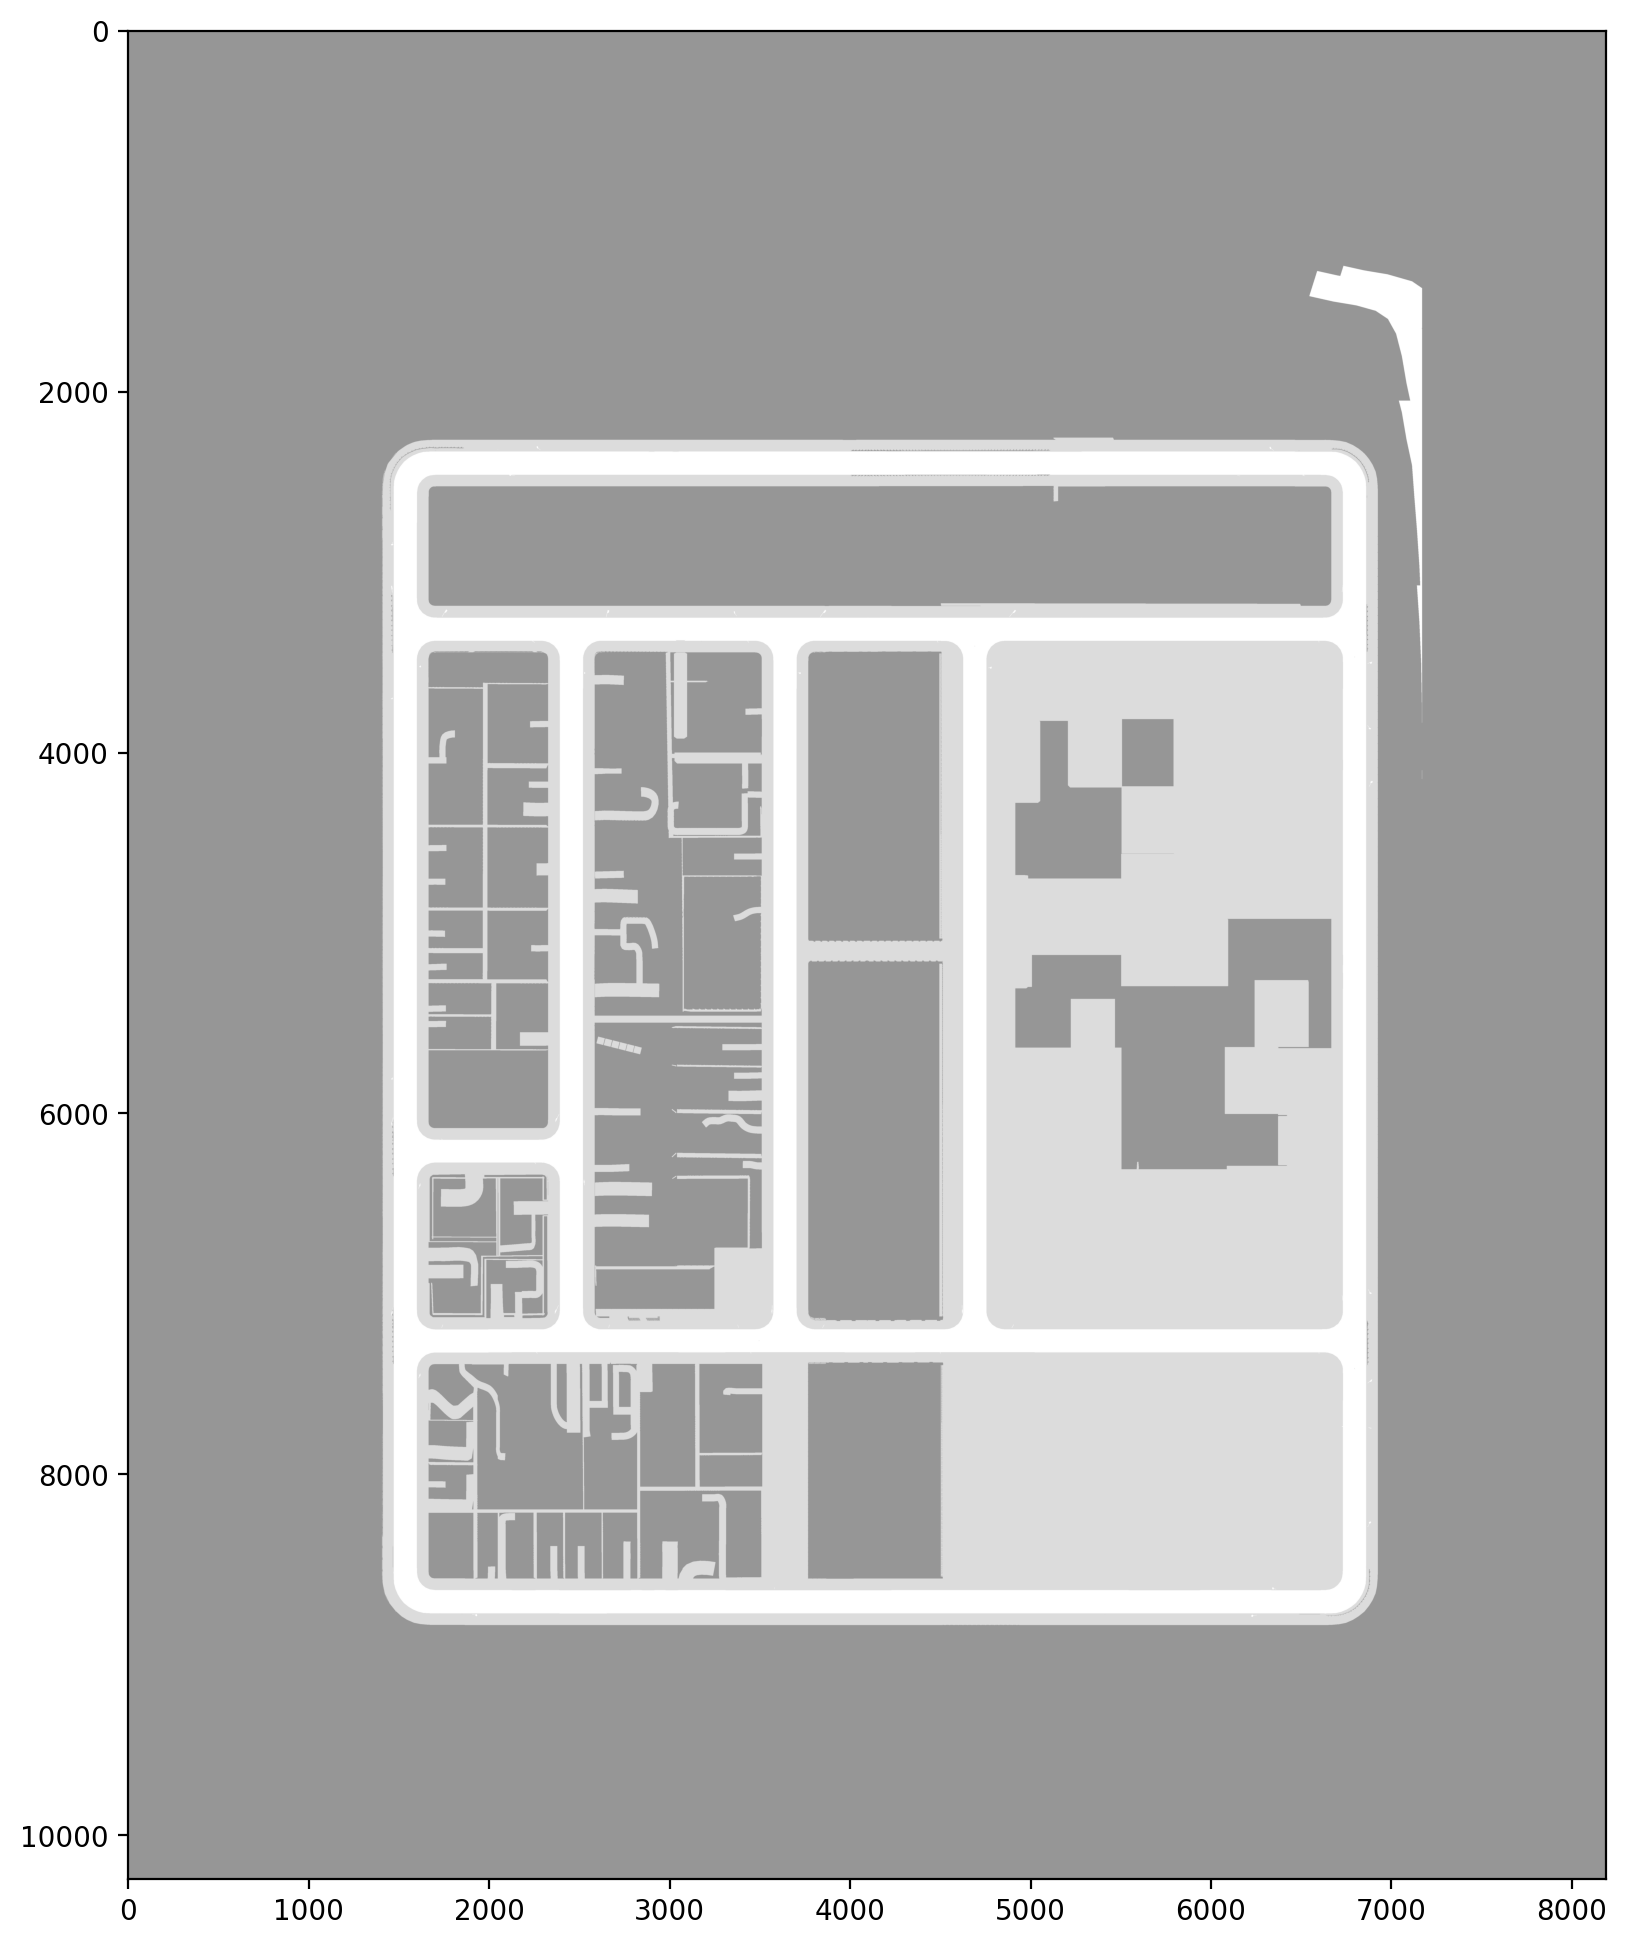

In [4]:
# Check map
plt.imshow(rgbmap)
plt.show()

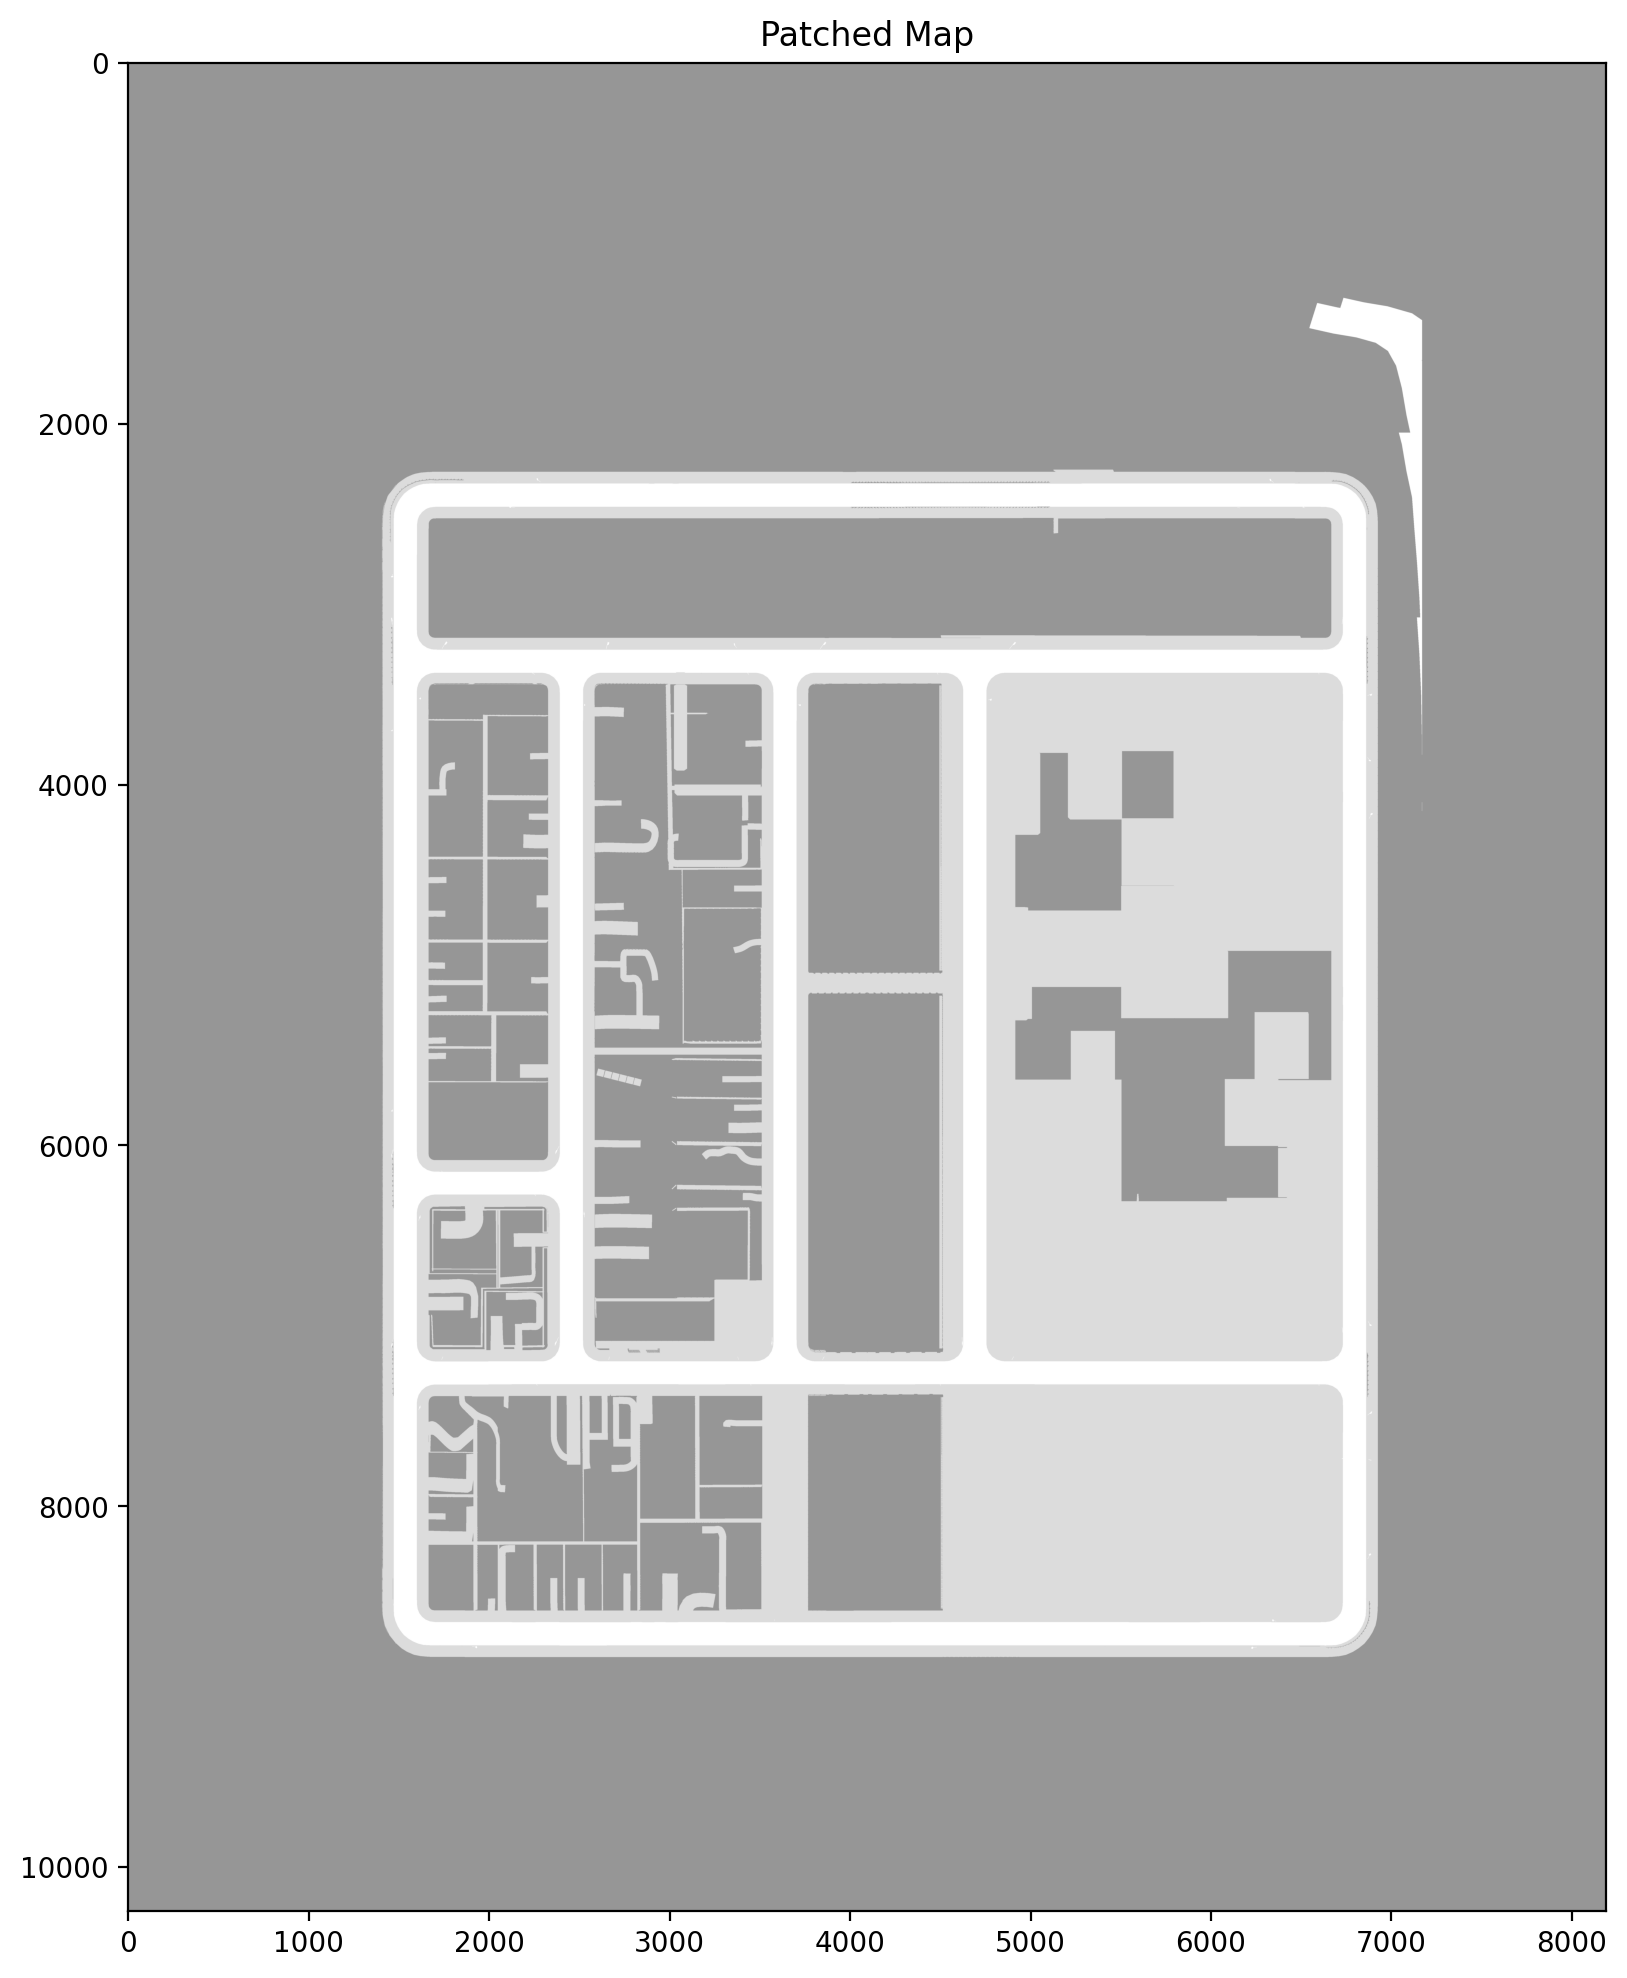

In [5]:
# Example: Patch a white rectangle at (y0, x0) with height h and width w

# If rgbmap is float [0,1], use 1.0; if uint8 [0,255], use 255
if rgbmap.dtype == np.uint8:
    white = 255
else:
    white = 1.0

y0, x0 = 7409, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3466, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 7256, 3492    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3406, 4689    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

plt.imshow(rgbmap)
plt.title("Patched Map")
plt.show()

In [6]:
intersections = [
    (8642, 1564),
    (8654, 6755),
    (7250, 1552),
    (7241, 2446),
    (7242, 3652),
    (7242, 4704),
    (7257, 6773),
    (6199, 1552),
    (6197, 2439),
    (3349, 1545),
    (3350, 2456),
    (3350, 3639),
    (3335, 4714),
    (3315, 6773),
    (2456, 1563),
    (2446, 6757),
 ]

intersections = [(y, x) for x, y in intersections]

In [7]:
map_edges = {}
for i, coord in enumerate(intersections):
    x, y = coord
    map_edges[i] = (x, y)

In [8]:
from skimage.color import rgb2gray
from skimage.morphology import skeletonize

def get_midlane_coords(rgbmap):
    gray = rgb2gray(rgbmap)
    binary = gray > 0.99  # Adjust threshold if needed
    # Skeletonize to get lane centerlines
    skeleton = skeletonize(binary)
    # Get coordinates of skeleton pixels (centerline points)
    centerline_coords = np.argwhere(skeleton)
    return centerline_coords

def sample_equidistant_points(path_coords, step=100):
    """Given a list of (y, x) coords, return equidistant points along the path."""
    path_coords = np.array(path_coords)
    # Compute cumulative distance along the path
    deltas = np.diff(path_coords, axis=0)
    dists = np.sqrt((deltas**2).sum(axis=1))
    cumdist = np.insert(np.cumsum(dists), 0, 0)
    total_dist = cumdist[-1]
    n_points = int(total_dist // step)
    if n_points < 2:
        return path_coords  # Path too short, return as is
    sample_dists = np.linspace(0, total_dist, n_points)
    sampled_points = np.empty((n_points, 2))
    sampled_points[0] = path_coords[0]
    sampled_points[-1] = path_coords[-1]
    j = 1
    for i in range(1, n_points-1):
        d = sample_dists[i]
        while cumdist[j] < d:
            j += 1
        ratio = (d - cumdist[j-1]) / (cumdist[j] - cumdist[j-1])
        sampled_points[i] = path_coords[j-1] + ratio * (path_coords[j] - path_coords[j-1])
    return sampled_points.astype(int)

def get_route_waypoints(pixel_graph, node_a, node_b ):
    # 2. For each consecutive pair, find pixel path and discretize
    pixel_path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(pixel_path, step=300)  # step in pixels
    return waypoints

def compute_lane_offsets(waypoints, lane_width=6.0):
    """
    Given centerline waypoints (N,2), return left and right lane waypoints.
    lane_width: total width of both lanes (in pixels, adjust as needed)
    """
    waypoints = np.array(waypoints)
    left_lane = []
    right_lane = []
    side_1, side_2 = [], []
    offset = lane_width / 2.0
    offset_ped = lane_width + 10

    for i in range(len(waypoints)):
        # Compute direction vector
        if i == 0:
            direction = waypoints[i+1] - waypoints[i]
        elif i == len(waypoints) - 1:
            direction = waypoints[i] - waypoints[i-1]
        else:
            direction = waypoints[i+1] - waypoints[i-1]
        direction = direction / np.linalg.norm(direction)
        # Normal vector (perpendicular, 2D)
        normal = np.array([-direction[1], direction[0]])
        # Offset points
        left_lane.append(waypoints[i] + offset * normal)
        right_lane.append(waypoints[i] - offset * normal)
        side_1.append(waypoints[i] + offset_ped * normal)
        side_2.append(waypoints[i] - offset_ped * normal)
    return np.array(left_lane), np.array(right_lane), np.array(side_1), np.array(side_2)


In [9]:
def show_route(rgbmap, waypoints):
    # 3. Visualize the full route
    plt.imshow(rgbmap)
    for idx, p in enumerate(intersections):
        plt.scatter(p[1], p[0], c='red', s=80, zorder=3)
        plt.annotate(str(idx), (p[1], p[0]), color='k', fontsize=12, weight='bold', zorder=4)
    plt.plot(waypoints[:,1], waypoints[:,0], 'orange', lw=2, zorder=5, label='Discretized Route')
    plt.scatter(waypoints[:,1], waypoints[:,0], c='b', s=1, zorder=6, label='Waypoints')
    plt.axis('off')
    plt.legend()
    plt.show()

In [10]:
centerline_coords = get_midlane_coords(rgbmap)
centerline_coords = centerline_coords[:, [1, 0]]

In [11]:
# 1. Find the closest centerline point for each intersection
intersection_nodes = []
for intersection in intersections:
    dists = np.linalg.norm(centerline_coords - intersection, axis=1)
    idx_min = np.argmin(dists)
    intersection_nodes.append(tuple(centerline_coords[idx_min]))

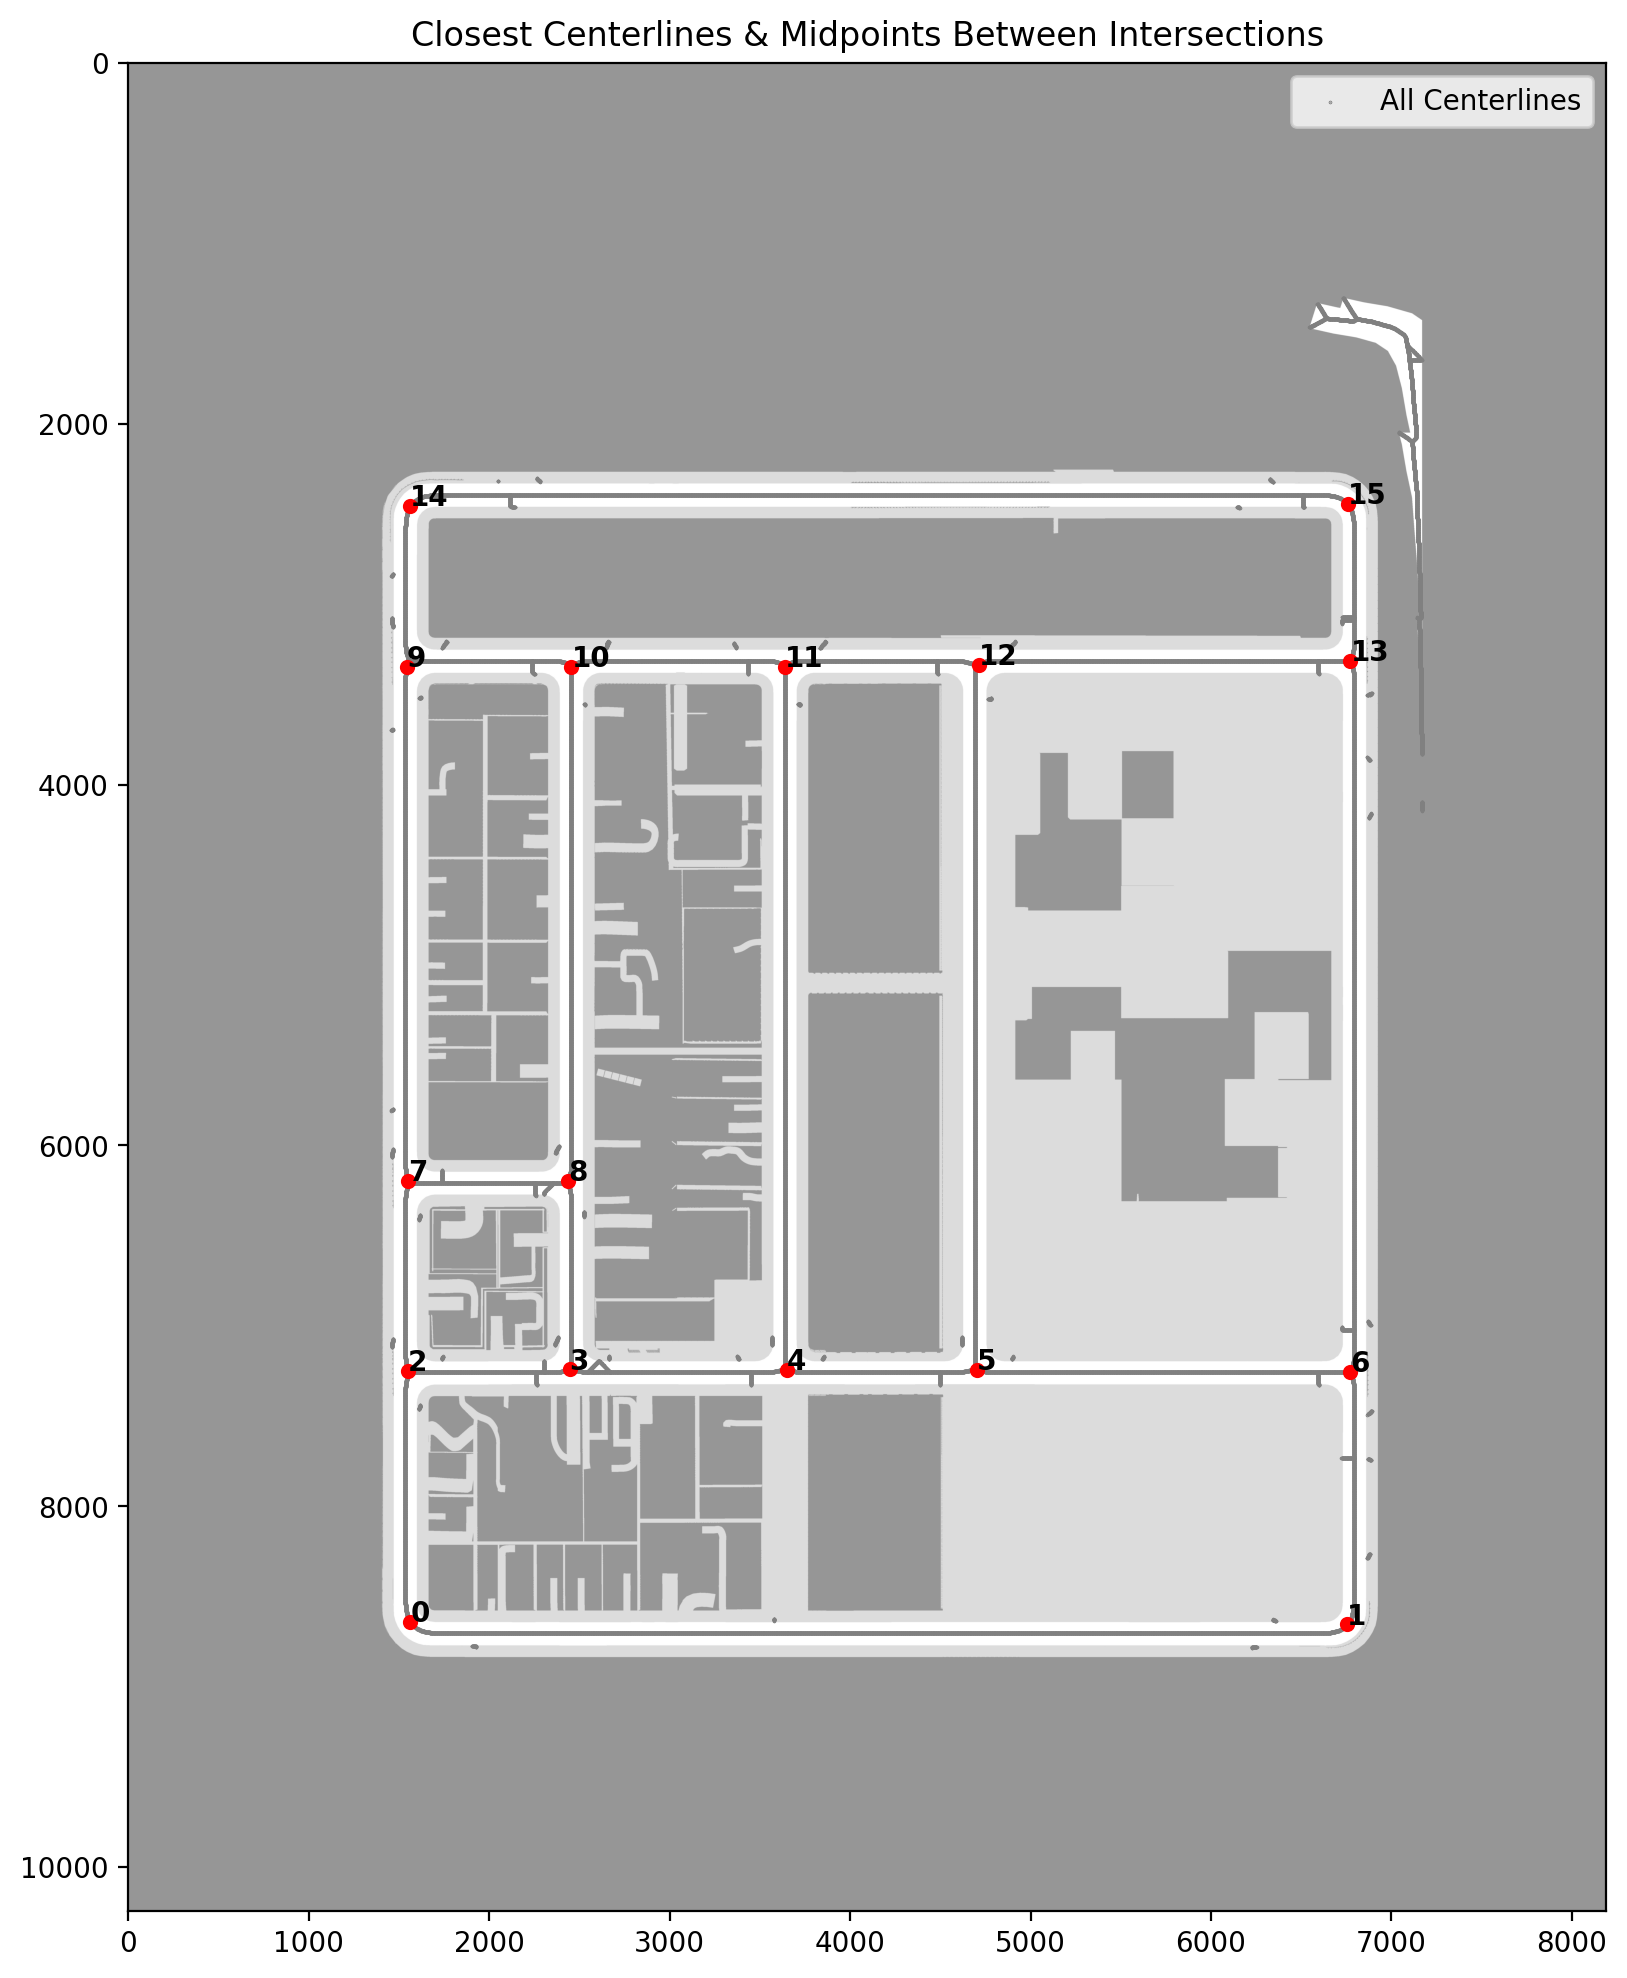

In [12]:
plt.imshow(rgbmap)
plt.scatter(centerline_coords[:,0], centerline_coords[:,1], c='gray', s=0.1, label='All Centerlines')
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
plt.legend()
plt.title("Closest Centerlines & Midpoints Between Intersections")
plt.show()

Direct intersection pairs (by index): [(0, 1), (0, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 5), (4, 11), (5, 6), (5, 12), (6, 13), (7, 8), (7, 9), (8, 10), (9, 10), (9, 14), (10, 11), (11, 12), (12, 13), (13, 15), (14, 15)]


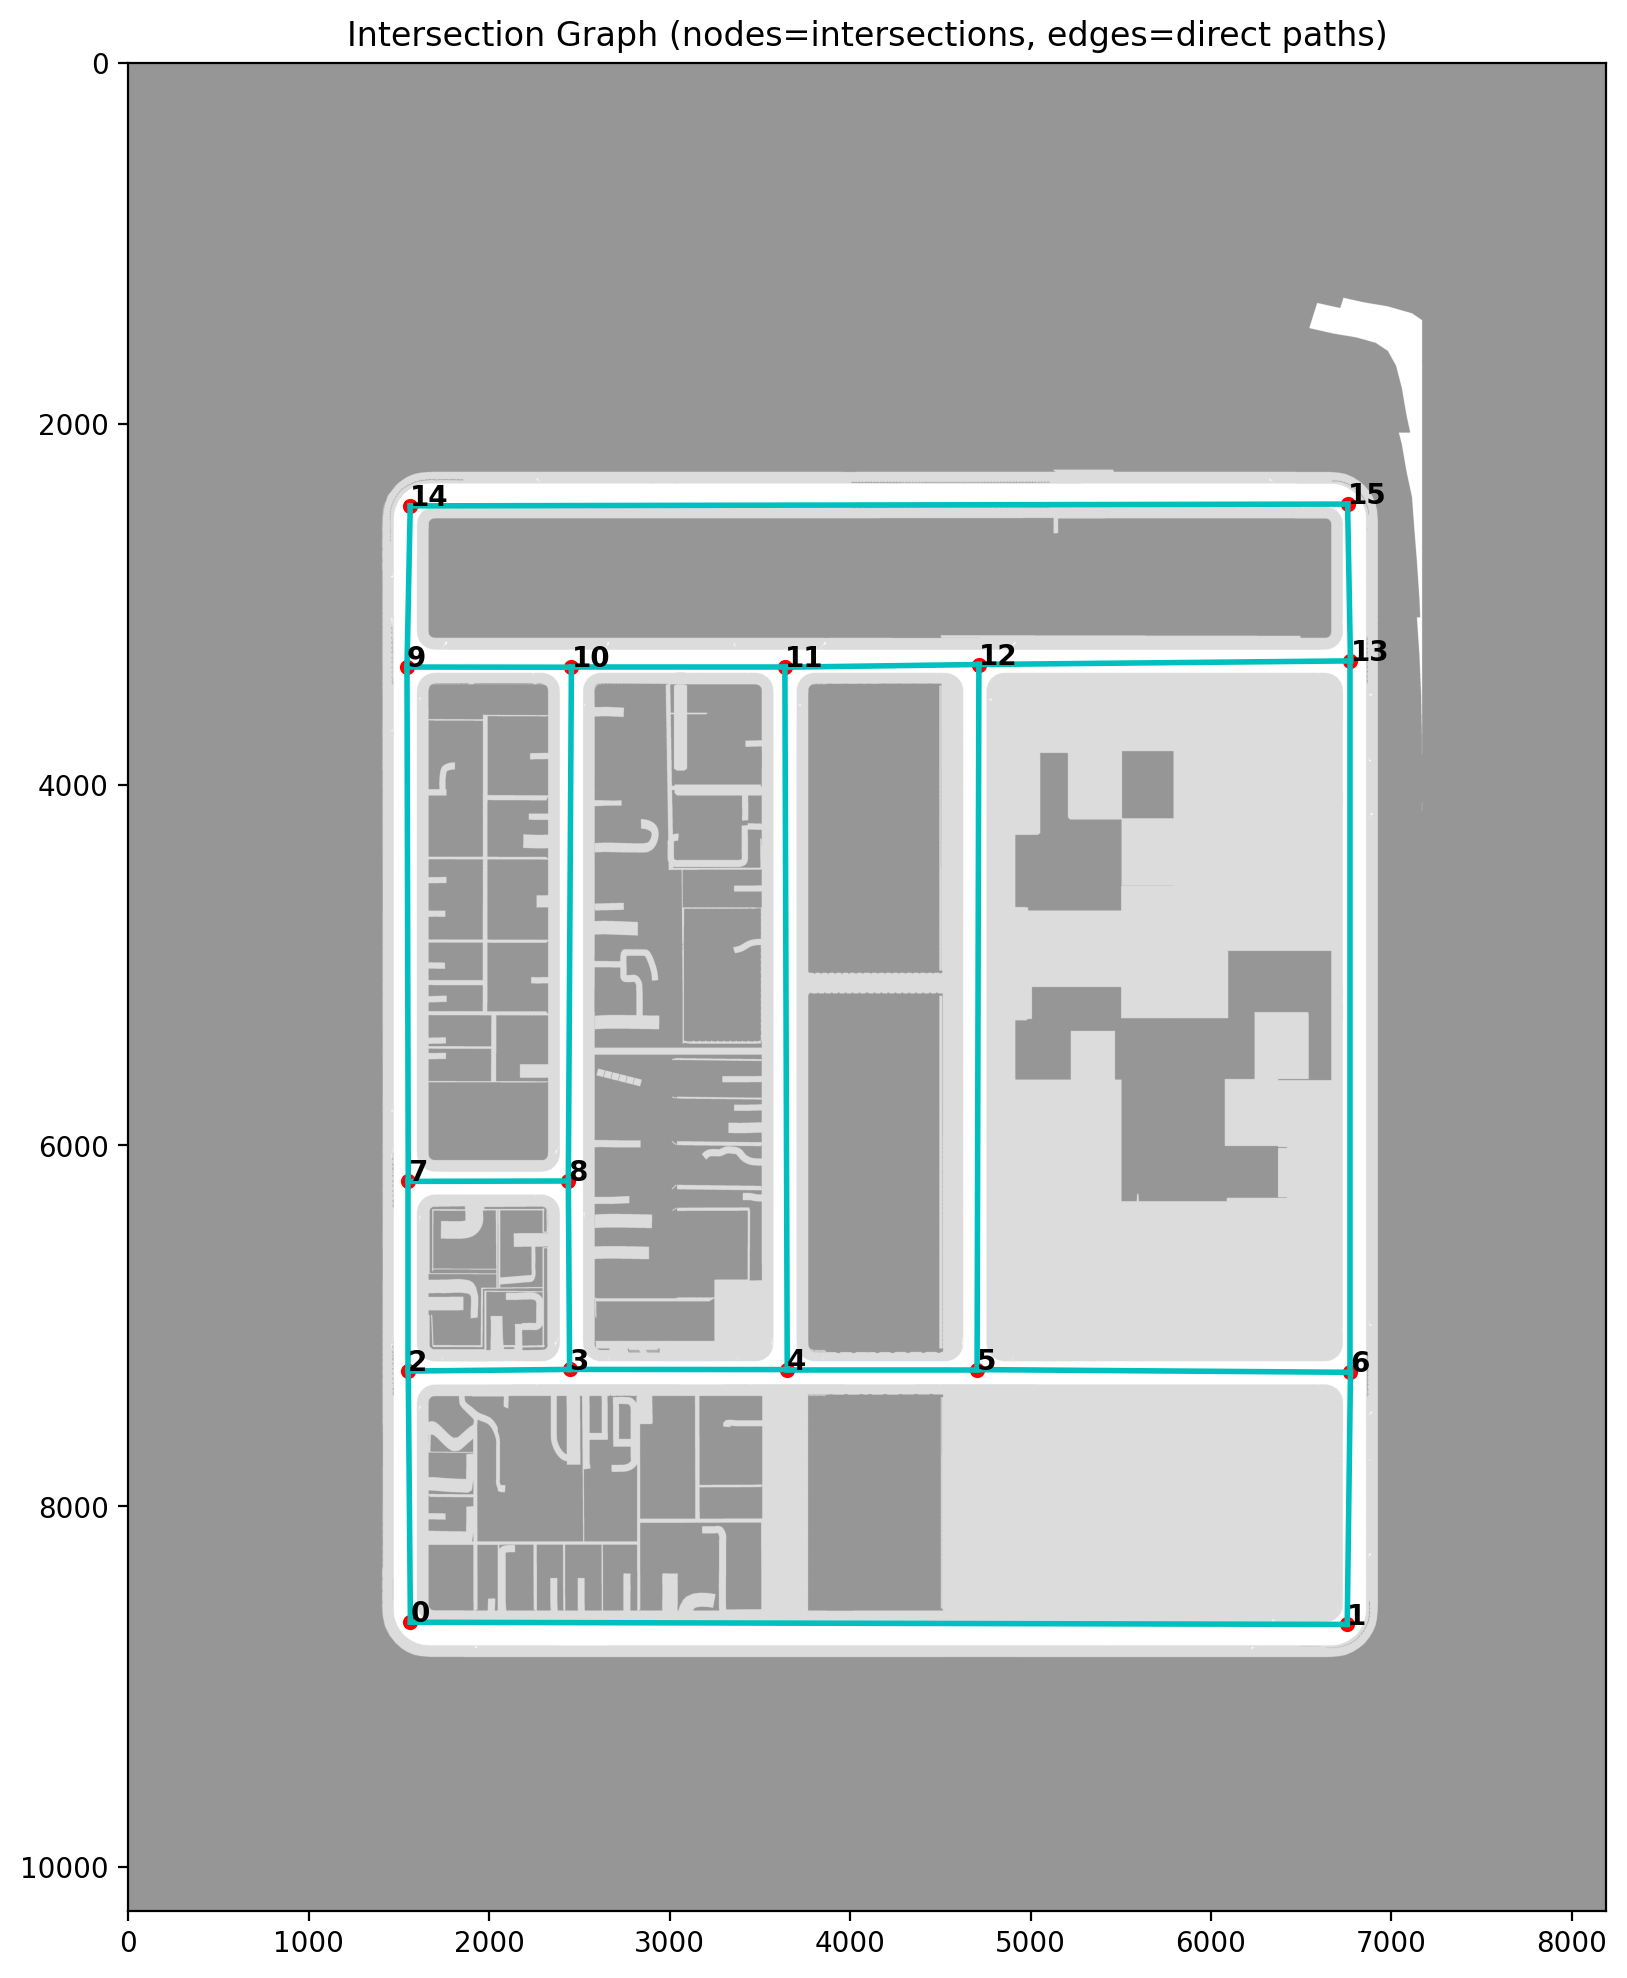

In [13]:
# 2. Build a pixel adjacency graph for centerline_coords (for pathfinding only)
pixel_graph = nx.Graph()
centerline_set = set(map(tuple, centerline_coords))
for y, x in centerline_coords:
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            neighbor = (y + dy, x + dx)
            if neighbor in centerline_set:
                pixel_graph.add_edge((y, x), neighbor)

# 3. Precompute a set of "blocked" pixels for each intersection (within a radius)
block_radius = 100  # pixels
blocked_pixels = []
for node in intersection_nodes:
    y0, x0 = node
    pixels = set()
    for dy in range(-block_radius, block_radius+1):
        for dx in range(-block_radius, block_radius+1):
            if dy**2 + dx**2 <= block_radius**2:
                pixels.add((y0+dy, x0+dx))
    blocked_pixels.append(pixels)

# 4. Build the intersection graph
G_intersections = nx.Graph()
for idx in range(len(intersections)):
    G_intersections.add_node(idx, pos=intersections[idx])

for i, node_a in enumerate(intersection_nodes):
    for j, node_b in enumerate(intersection_nodes):
        if i < j:
            try:
                path = nx.shortest_path(pixel_graph, node_a, node_b)
                path_set = set(path[1:-1])
                blocked = False
                for k, block in enumerate(blocked_pixels):
                    if k != i and k != j and path_set & block:
                        blocked = True
                        break
                if not blocked:
                    G_intersections.add_edge(i, j)
            except nx.NetworkXNoPath:
                continue

print("Direct intersection pairs (by index):", list(G_intersections.edges))

# Visualization
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
for i, j in G_intersections.edges:
    a = intersections[i]
    b = intersections[j]
    plt.plot([a[0], b[0]], [a[1], b[1]], 'c-', lw=2)
plt.title("Intersection Graph (nodes=intersections, edges=direct paths)")
plt.show()

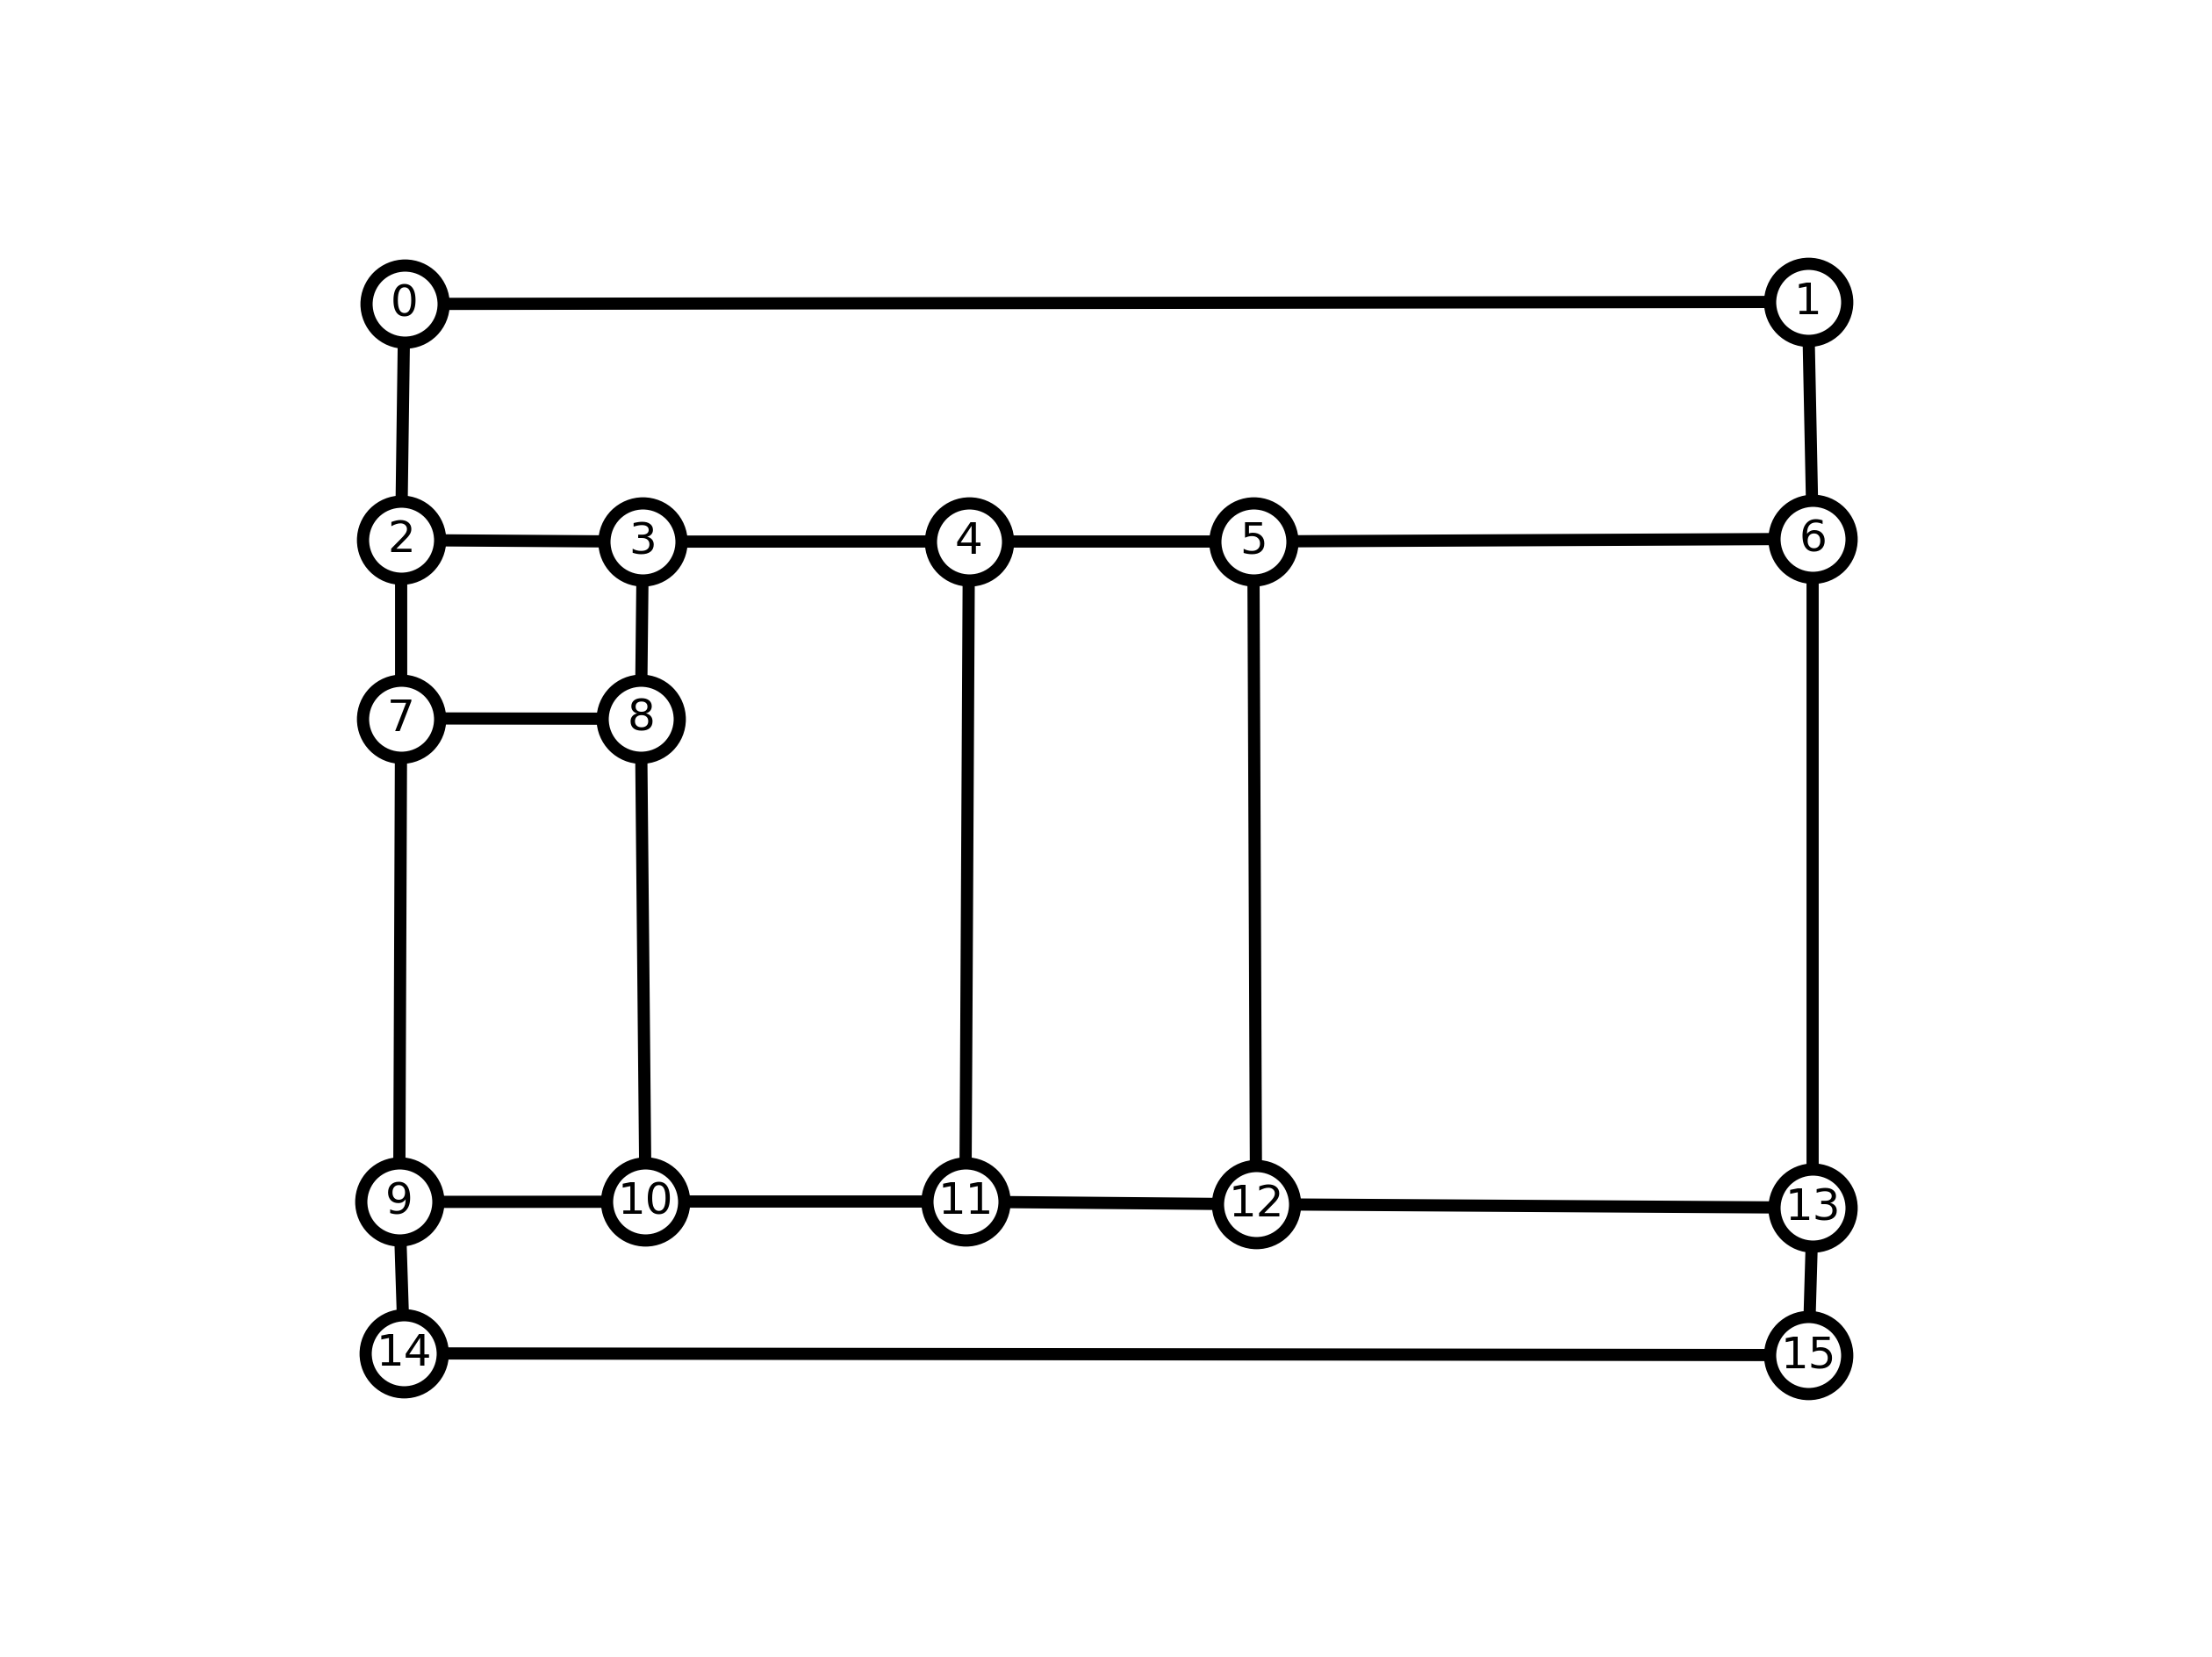

In [14]:
options = {
    "font_size": 18,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(G_intersections, map_edges, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [15]:
# Usage
lane_width_pixels = 80  # Adjust to your map's scale

# Example: Discretize all edges in G_intersections
edge_waypoints = {}
edge_lanes_r = {}
edge_lanes_l = {}
edge_ped_l = {}
edge_ped_r = {}
for i, j in G_intersections.edges:
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
    # Get the pixel path between intersections
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    # Sample equidistant points (e.g., every n pixels)
    waypoints = sample_equidistant_points(path, step=100)

    left_lane, right_lane, side1, side2 = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)
    edge_waypoints[(i, j)] = waypoints
    edge_lanes_r[(i, j)] = right_lane 
    edge_lanes_l[(i, j)] = left_lane 
    edge_ped_l[(i, j)] = side1 
    edge_ped_r[(i, j)] = side2




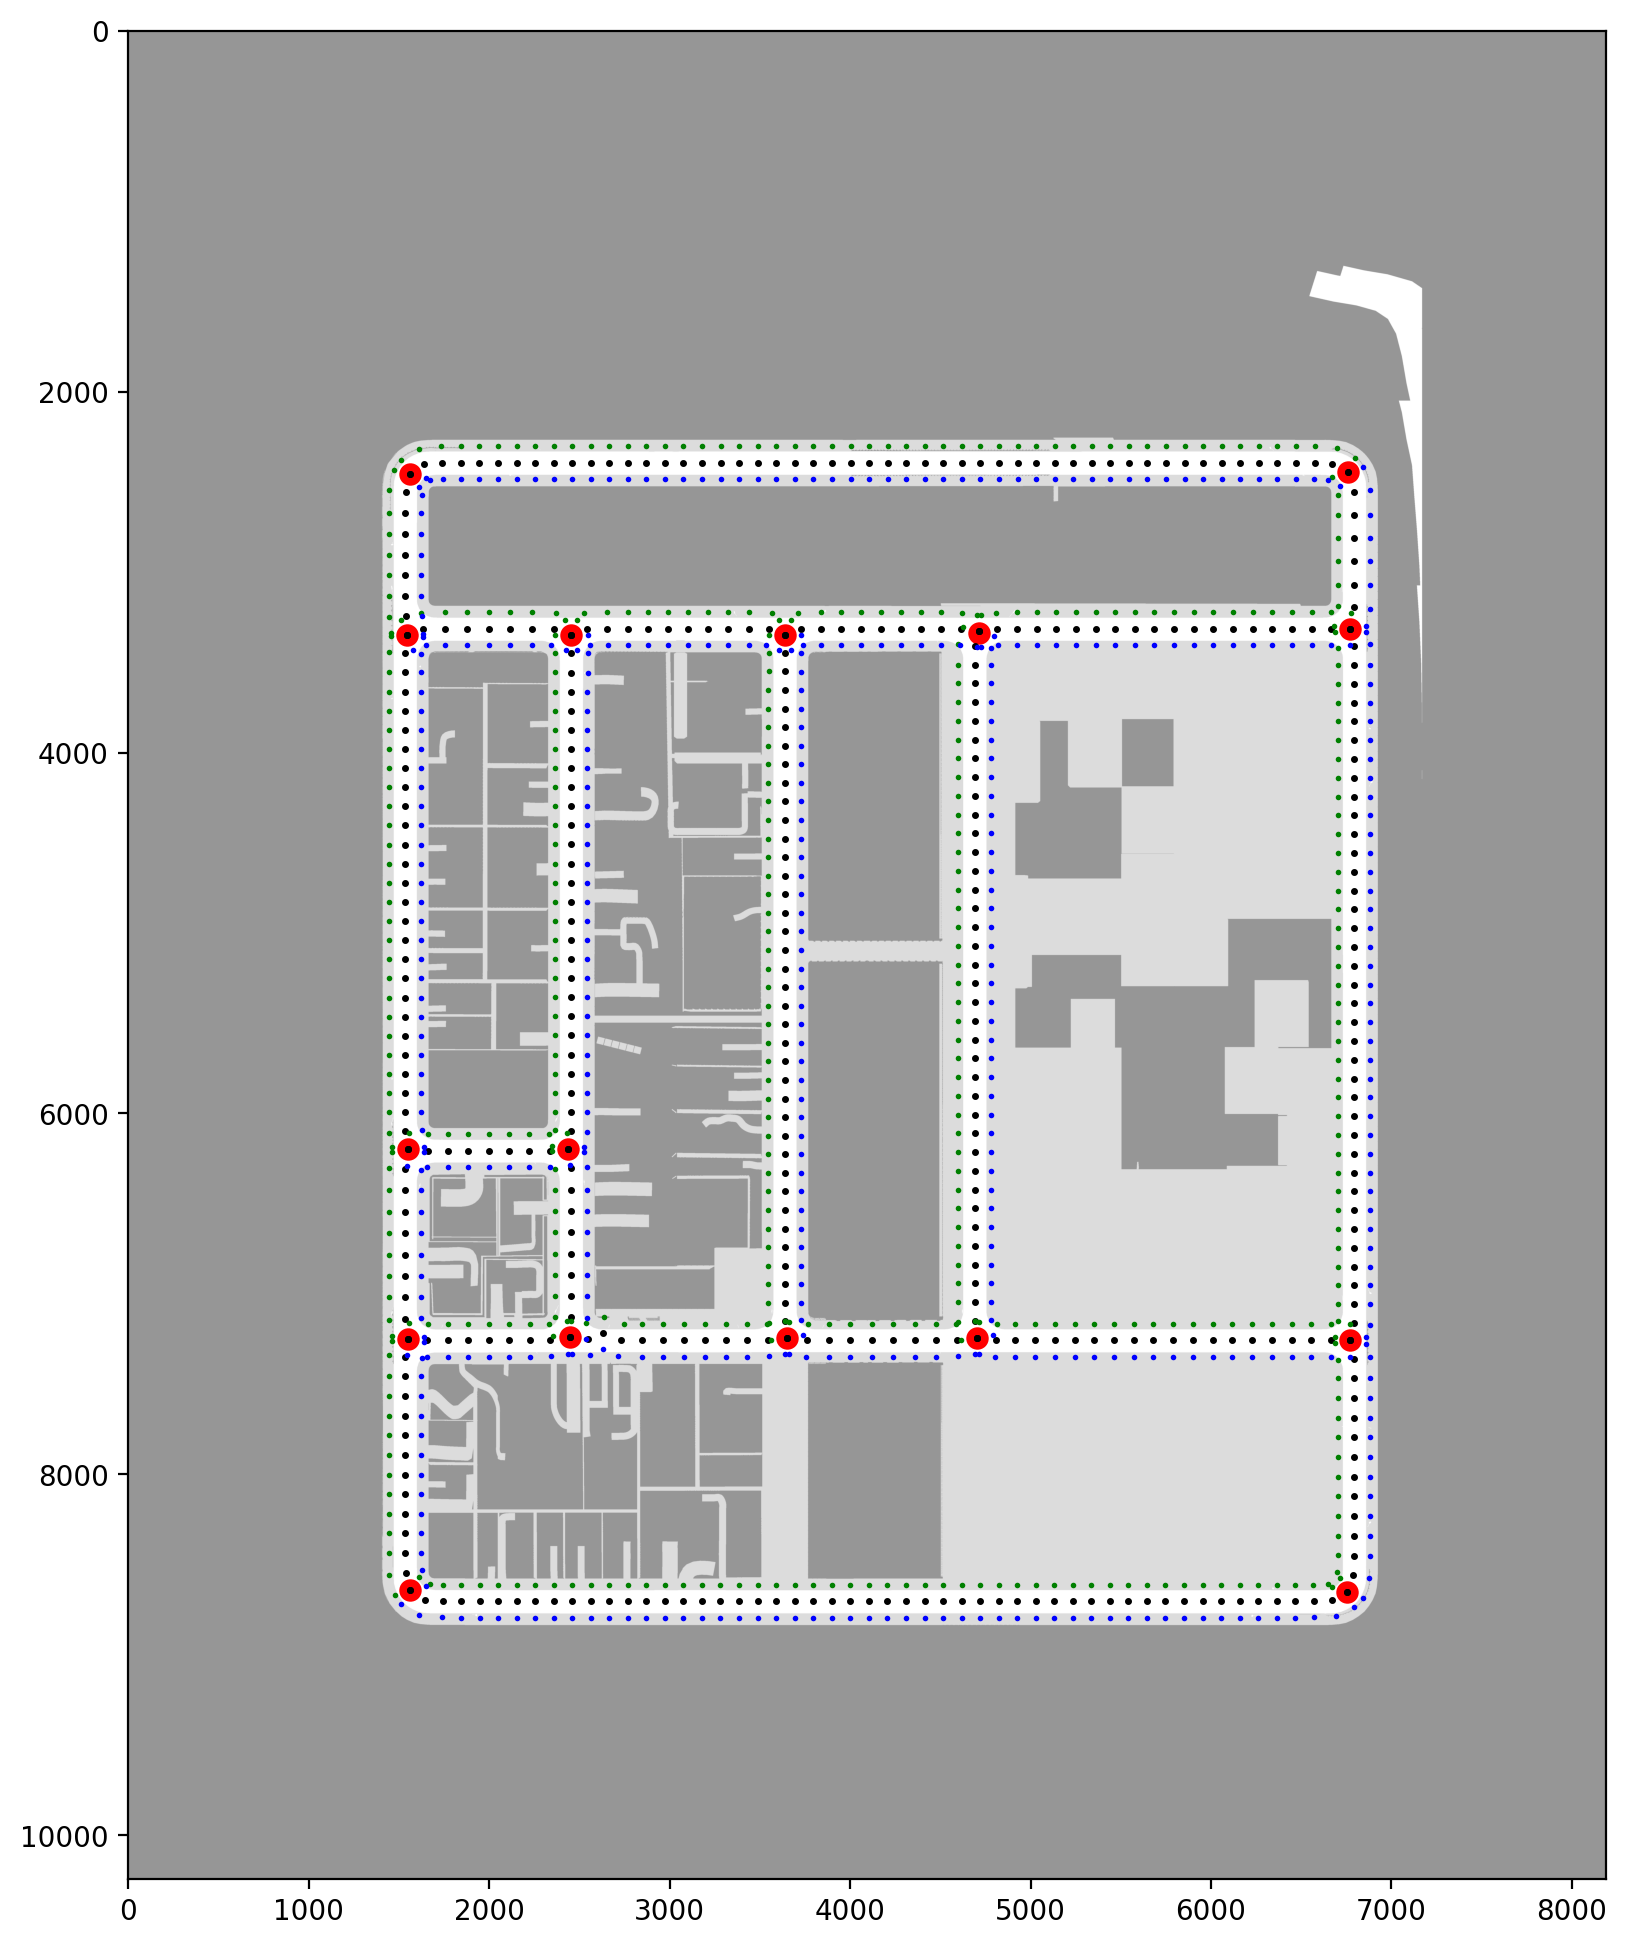

In [16]:
# Visualize one edge's waypoints
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for (i, j), waypoints in edge_waypoints.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'k.', markersize=3)

for (i, j), waypoints in edge_ped_r.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'g.', markersize=2)

for (i, j), waypoints in edge_ped_l.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'b.', markersize=2)

In [17]:
def get_closest_node(graph, point):
    # Assume graph nodes are (x, y) tuples
    return min(graph.nodes, key=lambda n: (n[0] - point[0])**2 + (n[1] - point[1])**2)


# GENERATE GRAPH!!!

In [ ]:
def add_center_waypoints(G, edge_id, centerline, cost_forward=1.0, lane="C", cost_to_intersection=0.1):
    """
    Adds centerline waypoints and connects them to intersection nodes.
    
    Parameters:
        G : networkx.Graph
            The planning graph to modify.
        edge_id : tuple
            A pair of intersection indices (i, j).
        centerline : list of (x, y)
            Waypoints along the road between i and j.
        cost_forward : float
            Cost of traveling forward along the centerline.
        cost_to_intersection : float
            Cost of entering or exiting an intersection.
    """
    edge_label = f"{edge_id[0]}-{edge_id[1]}"
    N = len(centerline)

    for i in range(N):
        c_node = f"{edge_label}_{lane}_{i}"
        G.add_node(c_node, pos=centerline[i], lane=lane)

        if i < N - 1:
            next_node = f"{edge_label}_{lane}_{i+1}"
            G.add_edge(c_node, next_node, cost=cost_forward)

    # --- Connect endpoints to intersections ---
    start_node = f"{edge_label}_{lane}_0"
    end_node = f"{edge_label}_{lane}_{N-1}"

    start_intersection = f"intersection_{edge_id[0]}"
    end_intersection = f"intersection_{edge_id[1]}"

    G.add_node(start_intersection, pos=centerline[0], lane="intersection")
    G.add_node(end_intersection, pos=centerline[-1], lane="intersection")

    G.add_edge(start_intersection, start_node, cost=cost_to_intersection)
    G.add_edge(start_node, start_intersection, cost=cost_to_intersection)

    G.add_edge(end_intersection, end_node, cost=cost_to_intersection)
    G.add_edge(end_node, end_intersection, cost=cost_to_intersection)

    return G


In [43]:

def add_waypoints_with_lanes(
    G, edge_id, waypoints, cost_forward=1.0, cost_to_intersection=0.1, cost_cross=5.0
):
    """
    Adds centerline + lane waypoints to the planning graph and connects them.

    Parameters:
        G : networkx.Graph
            The planning graph to modify.
        edge_id : tuple
            A pair of intersection indices (i, j).
        waypoints : dict
            Dictionary of lane polylines with keys "C", "L", "R".
            Each is a list of (x,y) coordinates of same length.
        cost_forward : float
            Cost of traveling forward along a lane.
        cost_to_intersection : float
            Cost of entering/exiting an intersection.
        cost_cross : float
            Cost of crossing horizontally (lane change).
    """
    edge_label = f"{edge_id[0]}-{edge_id[1]}"
    N = len(waypoints["C"])  # assume all lanes same length

    # --- Add nodes and vertical edges (forward along each lane) ---
    for i in range(N):
        for lane, coords in waypoints.items():
            node = f"{edge_label}_{lane}_{i}"
            try:
                pos = coords[i]
            except Exception as e:
                print(node)
                continue
            
            G.add_node(node, pos=tuple(pos), lane=lane)

            # vertical forward edge
            if i < N - 1:
                next_node = f"{edge_label}_{lane}_{i+1}"
                G.add_edge(node, next_node, cost=cost_forward)

        # --- Add horizontal cross edges at this index ---
        if all(lane in waypoints for lane in ["L", "C", "R"]):
            nL = f"{edge_label}_L_{i}"
            nC = f"{edge_label}_C_{i}"
            nR = f"{edge_label}_R_{i}"
            # L <-> C
            G.add_edge(nL, nC, cost=cost_cross)
            G.add_edge(nC, nL, cost=cost_cross)
            # C <-> R
            G.add_edge(nC, nR, cost=cost_cross)
            G.add_edge(nR, nC, cost=cost_cross)

    # --- Connect endpoints of all lanes to intersections ---
    start_intersection = f"intersection_{edge_id[0]}"
    end_intersection = f"intersection_{edge_id[1]}"

    G.add_node(start_intersection, pos=waypoints["C"][0], lane="intersection")
    G.add_node(end_intersection, pos=waypoints["C"][-1], lane="intersection")

    for lane in waypoints.keys():
        start_node = f"{edge_label}_{lane}_0"
        end_node = f"{edge_label}_{lane}_{N-1}"

        # connect start intersection
        G.add_edge(start_intersection, start_node, cost=cost_to_intersection)
        G.add_edge(start_node, start_intersection, cost=cost_to_intersection)

        # connect end intersection
        G.add_edge(end_intersection, end_node, cost=cost_to_intersection)
        G.add_edge(end_node, end_intersection, cost=cost_to_intersection)

    return G


In [44]:
def create_lane_graph(G, edge_id, edge_waypoints, waypoints, lane="center"):
    i,j = edge_id
    G = add_center_waypoints(G, edge_id=edge_id, centerline=waypoints, lane=lane)

    # After building each segment of waypoints for an edge (i, j):
    last_c = f"{i}-{j}_{lane}_{len(waypoints)-1}"

    # For all other edges connected to 'j'
    for neighbor in G_intersections.neighbors(j):
        if neighbor == i:
            continue
        neighbor_edge = (j, neighbor)
        neighbor_waypoints = edge_waypoints.get(neighbor_edge) or edge_waypoints.get((neighbor, j))
        if neighbor_waypoints is None:
            continue
        first_neighbor_c = f"{j}-{neighbor}_{lane}_0"
        G.add_edge(last_c, first_neighbor_c, cost=1.0)  # You can tune the cost

    return G


import networkx as nx
import matplotlib.pyplot as plt

# --- Parameters ---
lane_width_pixels = 80  # Adjust to your map's scale
sample_step = 100       # Step size for waypoint sampling
add_lanes = False

# --- Containers ---
edge_waypoints = {}
edge_lanes_r = {}
edge_lanes_l = {}
edge_ped_r = {}
edge_ped_l = {}

# --- Full planning graph ---
G_center = G_intersections.copy()
G_left = G_intersections.copy()
G_right = G_intersections.copy()
G_ped = G_intersections.copy()

# --- Main loop ---
for i, j in G_intersections.edges:
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
     # Get path in pixel_graph and sample waypoints
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(path, step=sample_step)

    # Compute lane offsets
    left_lane, right_lane, side_1, side_2 = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)

    # Save for visualization/debugging
    edge_waypoints[(i, j)] = waypoints
    edge_lanes_l[(i, j)] = left_lane
    edge_lanes_r[(i, j)] = right_lane
    edge_ped_l[(i, j)] = side_1
    edge_ped_r[(i, j)] = side_2
            

    G_center = create_lane_graph(G_center, edge_id=(i,j),
     edge_waypoints=edge_waypoints, waypoints=waypoints, lane="C")

    G_left= create_lane_graph(G_left, edge_id=(i,j),
     edge_waypoints=edge_lanes_l, waypoints=left_lane, lane="L")

    G_right= create_lane_graph(G_right, edge_id=(i,j),
     edge_waypoints=edge_lanes_r, waypoints=right_lane, lane="R")
     
    graph_waypoints = {
        "C": waypoints,
        "L": side_1,
        "R": side_2,
    }
     
    G_ped = add_waypoints_with_lanes(G_ped, edge_id=(i,j), waypoints=graph_waypoints)

In [20]:
merge_threshold = 10
# --- Merge redundant nodes ---
pos = nx.get_node_attributes(G_planning, 'pos')
positions = list(pos.items())

for i in range(len(positions)):
    node_i, pos_i = positions[i]
    for j in range(i+1, len(positions)):
        node_j, pos_j = positions[j]
        if np.linalg.norm(np.array(pos_i) - np.array(pos_j)) < merge_threshold:
            # Merge node_j into node_i
            if node_j in G_planning and node_i in G_planning:
                nx.relabel_nodes(G_planning, {node_j: node_i}, copy=False)

In [45]:
for node_id in G_center.nodes:
    print(G_center.nodes[node_id])

{'pos': (1564, 8642)}
{'pos': (6755, 8654)}
{'pos': (1552, 7250)}
{'pos': (2446, 7241)}
{'pos': (3652, 7242)}
{'pos': (4704, 7242)}
{'pos': (6773, 7257)}
{'pos': (1552, 6199)}
{'pos': (2439, 6197)}
{'pos': (1545, 3349)}
{'pos': (2456, 3350)}
{'pos': (3639, 3350)}
{'pos': (4714, 3335)}
{'pos': (6773, 3315)}
{'pos': (1563, 2456)}
{'pos': (6757, 2446)}
{'pos': array([1564, 8642]), 'lane': 'C'}
{'pos': array([1643, 8694]), 'lane': 'C'}
{'pos': array([1742, 8703]), 'lane': 'C'}
{'pos': array([1845, 8703]), 'lane': 'C'}
{'pos': array([1947, 8703]), 'lane': 'C'}
{'pos': array([2050, 8703]), 'lane': 'C'}
{'pos': array([2153, 8703]), 'lane': 'C'}
{'pos': array([2256, 8703]), 'lane': 'C'}
{'pos': array([2358, 8703]), 'lane': 'C'}
{'pos': array([2461, 8704]), 'lane': 'C'}
{'pos': array([2564, 8704]), 'lane': 'C'}
{'pos': array([2666, 8703]), 'lane': 'C'}
{'pos': array([2769, 8703]), 'lane': 'C'}
{'pos': array([2871, 8703]), 'lane': 'C'}
{'pos': array([2974, 8703]), 'lane': 'C'}
{'pos': array([307

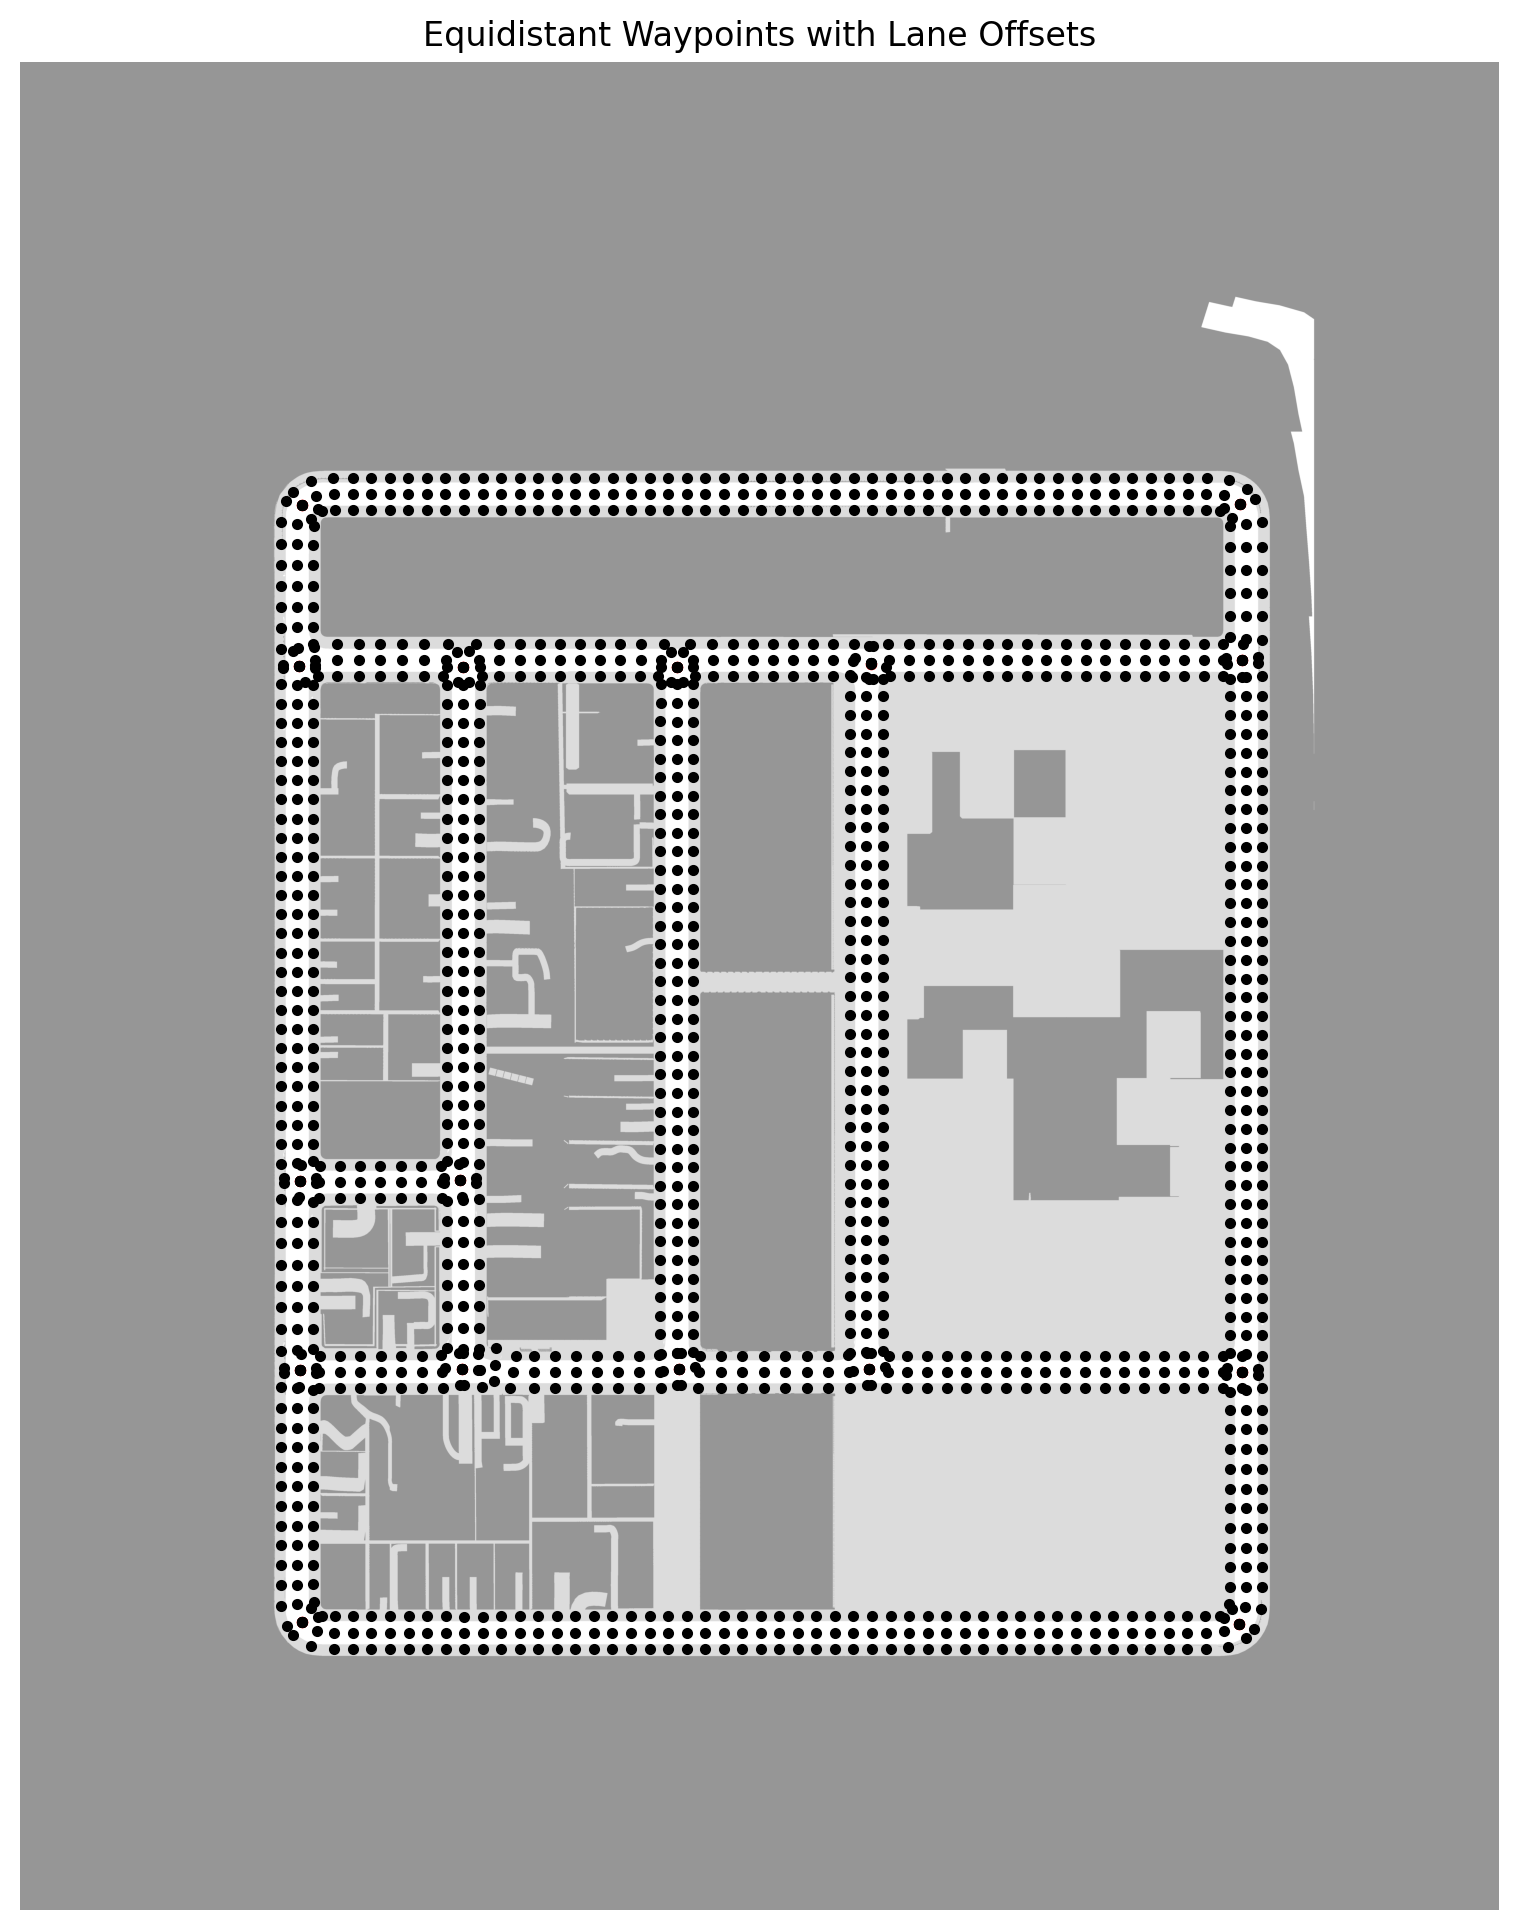

In [48]:
# --- Optional: Visualization ---
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=10)

for node_id in G_ped.nodes:
    try:
        pos = G_ped.nodes[node_id]['pos']
        plt.plot(pos[0], pos[1], 'k.', linewidth=0.3)
    except:
        print(node_id)
        continue



plt.title("Equidistant Waypoints with Lane Offsets")
plt.axis('off')
plt.show()

In [49]:
import pickle

# Save
with open("town01-center.pkl", "wb") as f:
    pickle.dump(G_center, f)

with open("town01-left.pkl", "wb") as f:
    pickle.dump(G_left, f)

with open("town01-right.pkl", "wb") as f:
    pickle.dump(G_right, f)


with open("town01-ped.pkl", "wb") as f:
    pickle.dump(G_right, f)

# EXPAND GRAPH

In [15]:
import pickle
# Load
with open("town01-center.pkl", "rb") as f:
    G_base = pickle.load(f)

In [16]:
def build_semantic_lane_graph(centerline, edge_id=(0,1),
                              lane_offsets=None,
                              lane_types=None,
                              cost_forward_dict=None,
                              cost_cross_dict=None,
                              cost_diag_dict=None,
                              cost_to_intersection=0.1,
                              G=None):
    """
    Add lanes and intersections to an existing graph G (or create a new one).
    
    Parameters:
        G: networkx.DiGraph or None
            Existing graph to update. If None, a new graph is created.
        Other params as before...
    """
    import networkx as nx
    import numpy as np

    if G is None:
        G = nx.DiGraph()

    if lane_offsets is None:
        lane_offsets = [3.5, 0.0, -3.5]
    if lane_types is None:
        lane_types = ["vehicle"] * len(lane_offsets)

    # Same cost dict defaults as before...
    if cost_forward_dict is None:
        cost_forward_dict = {lt: 1.0 for lt in set(lane_types)}
    if cost_cross_dict is None:
        cost_cross_dict = {}
        for lt in set(lane_types):
            cost_cross_dict[(lt, lt)] = 5.0
        for lt1 in set(lane_types):
            for lt2 in set(lane_types):
                if lt1 != lt2:
                    cost_cross_dict[(lt1, lt2)] = 20.0
                    cost_cross_dict[(lt2, lt1)] = 20.0
    if cost_diag_dict is None:
        cost_diag_dict = cost_cross_dict

    edge_label = f"{edge_id[0]}-{edge_id[1]}"
    centerline = np.array(centerline)
    N = len(centerline)

    def compute_offset_points(points, offset_dist):
        offsets = []
        for i in range(len(points)):
            if i == len(points) - 1:
                direction = points[i] - points[i - 1]
            else:
                direction = points[i + 1] - points[i]
            norm_dir = direction / np.linalg.norm(direction)
            perp = np.array([-norm_dir[1], norm_dir[0]])
            offsets.append(points[i] + perp * offset_dist)
        return np.array(offsets)

    lane_coords = [compute_offset_points(centerline, off) for off in lane_offsets]
    lane_names = [f"L{i}" for i in range(len(lane_offsets))]

    # Add nodes if they don't exist yet
    for lane_name, coords, lane_type in zip(lane_names, lane_coords, lane_types):
        for i, pos in enumerate(coords):
            node = f"{edge_label}_{lane_name}_{i}"
            if node not in G:
                G.add_node(node, pos=pos, lane=lane_name, semantic=lane_type)

    # Add edges (vertical, horizontal, diagonal) - just add or overwrite
    for lane_name, lane_type in zip(lane_names, lane_types):
        forward_cost = cost_forward_dict.get(lane_type, 1.0)
        for i in range(N - 1):
            node1 = f"{edge_label}_{lane_name}_{i}"
            node2 = f"{edge_label}_{lane_name}_{i+1}"
            G.add_edge(node1, node2, cost=forward_cost, relation='forward')

    for i in range(N):
        for j in range(len(lane_names) - 1):
            node1 = f"{edge_label}_{lane_names[j]}_{i}"
            node2 = f"{edge_label}_{lane_names[j + 1]}_{i}"
            lt1 = lane_types[j]
            lt2 = lane_types[j + 1]
            cross_cost = cost_cross_dict.get((lt1, lt2), 20.0)
            G.add_edge(node1, node2, cost=cross_cost, relation='horizontal')
            G.add_edge(node2, node1, cost=cross_cost, relation='horizontal')

    for i in range(N - 1):
        for j in range(1, len(lane_names)):
            node_curr = f"{edge_label}_{lane_names[j]}_{i}"
            node_left_next = f"{edge_label}_{lane_names[j - 1]}_{i + 1}"
            lt_curr = lane_types[j]
            lt_left = lane_types[j - 1]
            diag_cost = cost_diag_dict.get((lt_curr, lt_left), 20.0)
            G.add_edge(node_curr, node_left_next, cost=diag_cost, relation='diagonal')
            G.add_edge(node_left_next, node_curr, cost=diag_cost, relation='diagonal')

    # Add intersection nodes only if not present
    start_intersection = f"intersection_{edge_id[0]}"
    end_intersection = f"intersection_{edge_id[1]}"

    if start_intersection not in G:
        G.add_node(start_intersection, pos=centerline[0], lane="intersection", semantic="intersection")
    if end_intersection not in G:
        G.add_node(end_intersection, pos=centerline[-1], lane="intersection", semantic="intersection")

    # Connect lane endpoints to intersections
    for lane_name in lane_names:
        start_node = f"{edge_label}_{lane_name}_0"
        end_node = f"{edge_label}_{lane_name}_{N-1}"
        G.add_edge(start_intersection, start_node, cost=cost_to_intersection, relation='intersection')
        G.add_edge(start_node, start_intersection, cost=cost_to_intersection, relation='intersection')
        G.add_edge(end_intersection, end_node, cost=cost_to_intersection, relation='intersection')
        G.add_edge(end_node, end_intersection, cost=cost_to_intersection, relation='intersection')

    return G


In [17]:
lane_offsets = [90, 40, 0, -40, -90]
lane_types = ["sidewalk", "vehicle", "vehicle", "vehicle", "sidewalk"]

cost_forward_dict = {
    "vehicle": 1.0,
    "intersection": 2.0,
    "sidewalk": 3.0,
    
}

cost_cross_dict = {
    ("vehicle", "vehicle"): 1.5,
    ("vehicle", "sidewalk"): 10.0,
    ("sidewalk", "sidewalk"): 10.0,
    ("sidewalk", "vehicle"): 3.0,
}

cost_diag_dict = {
    ("vehicle", "vehicle"): 1.0,
    ("vehicle", "sidewalk"): 5.0,
    ("sidewalk", "sidewalk"): 3.0,
    ("sidewalk", "vehicle"): 5.0
}

# --- Full planning graph ---
G_final = G_intersections.copy()

# --- Main loop ---
for i, j in G_intersections.edges:
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
     # Get path in pixel_graph and sample waypoints
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(path, step=25)

    G_final = build_semantic_lane_graph(waypoints, 
                                  edge_id=(i, j),
                                  lane_offsets=lane_offsets,
                                  lane_types=lane_types,
                                  cost_forward_dict=cost_forward_dict,
                                  cost_cross_dict=cost_cross_dict,
                                  cost_diag_dict=cost_diag_dict,
                                  cost_to_intersection=1.0,
                                  G=G_final)

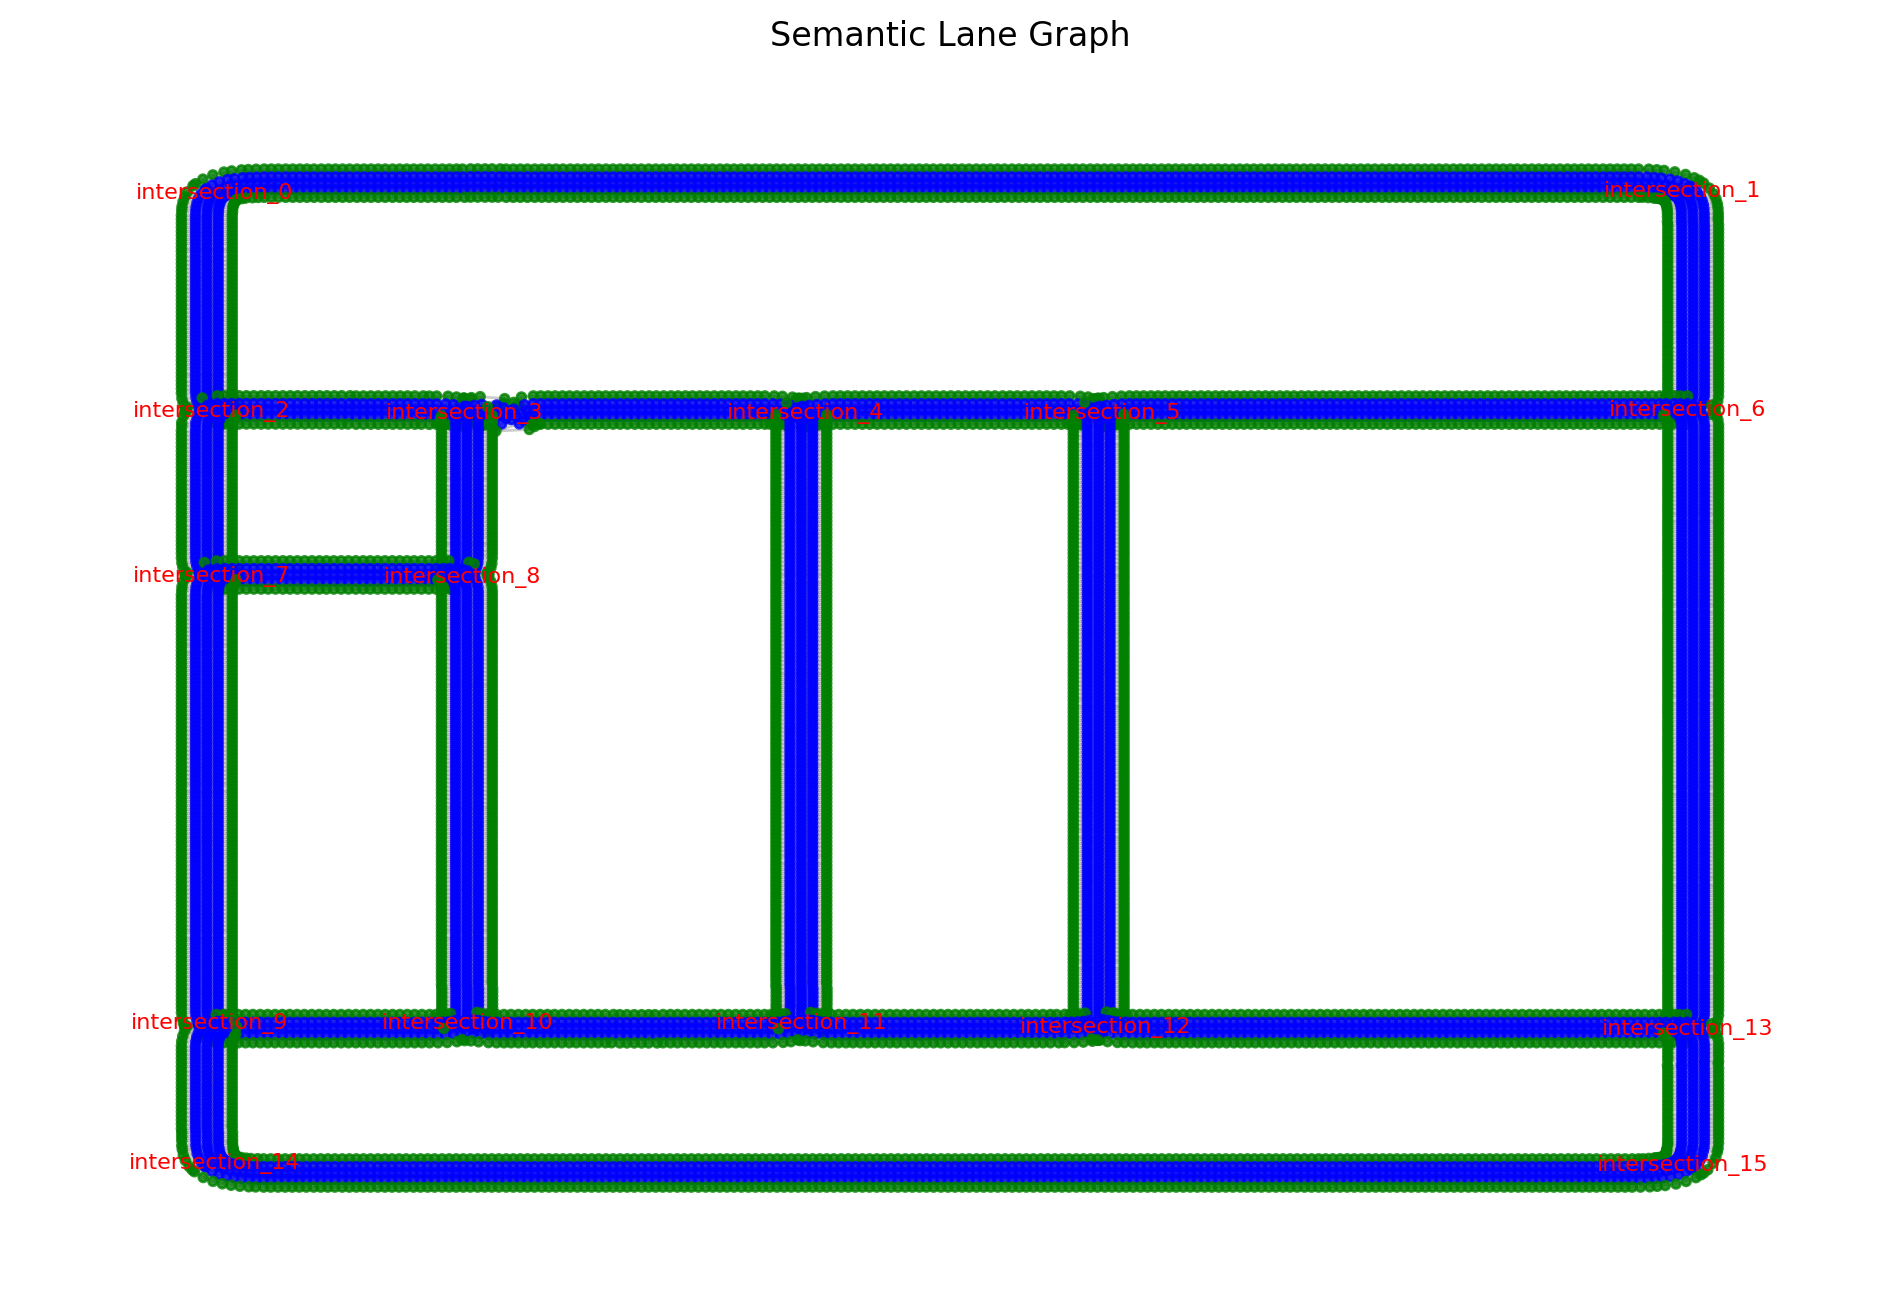

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph(G):
    plt.figure(figsize=(12, 8))

    # Extract node positions
    pos = {node: data['pos'] for node, data in G.nodes(data=True)}

    # Extract semantic labels for coloring
    semantics = [data.get('semantic', 'unknown') for _, data in G.nodes(data=True)]
    unique_semantics = list(set(semantics))

    # Assign colors to semantics
    colors_map = {
        'vehicle': 'blue',
        'sidewalk': 'green',
        'intersection': 'red',
        'unknown': 'gray'
    }
    # Fallback for unknown semantics
    node_colors = [colors_map.get(sem, 'gray') for sem in semantics]

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10, alpha=0.8)

    # Draw edges with light gray color
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')

    # Optional: draw labels for intersections or lane names
    labels = {}
    for node, data in G.nodes(data=True):
        if data.get('semantic') == 'intersection':
            labels[node] = node
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='red')

    plt.axis('off')
    plt.title("Semantic Lane Graph")
    plt.show()

# Usage
draw_graph(G_final)


In [18]:
with open("town01-25.pkl", "wb") as f:
    pickle.dump(G_final, f)